# Section 0: Import section

In [14]:
# NLP helper functions
from nltk.stem import PorterStemmer
from textblob import TextBlob
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.sentiment import SentimentIntensityAnalyzer

# data science
import numpy as np
from numpy import savetxt
from numpy import loadtxt
from tqdm import tqdm
from transformers import BertTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd

# scikit-learn
import sklearn
from sklearn.metrics import classification_report


# python standard library
import math
import time
import csv
import random

# create functions
from helper_func_and_classes import create_dataset_list, create_submission_file, create_vocab

# helper functions
from helper_func_and_classes import split_dataset
from helper_func_and_classes import output_numpy_array_from_model_training
from helper_func_and_classes import output_numpy_array_from_model_submission

# wordembedding functions
from helper_func_and_classes import word_embeddings_extraction
from helper_func_and_classes import get_count_of_longest_sentence

# helper Classes
from helper_func_and_classes import TwitterDataset


# pytorch 
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset
from torchtext.vocab import GloVe
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms

# sentence transformers
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizerFast

# plotting 
import matplotlib.pyplot as plt

RANDOM_SEED = 123
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);


# Section 1: Data preprocessing section
## Section 1.1: Creating lists of sentences

In [2]:
pos_data = create_dataset_list("./twitter-datasets/train_pos_full.txt")
neg_data = create_dataset_list("./twitter-datasets/train_neg_full.txt")

submission_data = create_dataset_list("./twitter-datasets/test_data.txt")

print("Length of submission_data: ",len(submission_data))

Length of submission_data:  10000


## Section 1.2: Sentence embeddings
In this section we will load in the sentence model from huggingface and encode the sentences. This part is pretty compute intensive and will take around 7-8 hours to finish. So to speed up this process, the embeddings have already been created and written to file. Change `sentence_transformer_created = False` to redo the encoding and write to file.

source: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [3]:
sentence_transformer_created = True

if not sentence_transformer_created:
    level_1_sentence_transformer = 'sentence-transformers/all-MiniLM-L6-v2'
    #level_2_sentence_transformer = 'sentence-transformers/all-MiniLM-L12-v2'
    #level_3_sentence_transformer = 'sentence-transformers/all-mpnet-base-v2'
    sentence_model = SentenceTransformer(level_1_sentence_transformer)

In [4]:
if not sentence_transformer_created:
    print("pos_data length: ", len(pos_data))
    print("neg_data length: ", len(neg_data))
    print("submission_data length: ", len(submission_data))
    full_data_list = pos_data + neg_data + submission_data
    sentence_embeddings = sentence_model.encode(full_data_list, batch_size=256, show_progress_bar=True)

### Section 1.2.1: Writing sentence embeddings to file

In [5]:
# saving word embeddings to file type 'sentence-transformers/all-MiniLM-L6-v2'
if not sentence_transformer_created:
    savetxt('./word_embeddings/full_full_data_list_sentence_embeddings.csv', sentence_embeddings, delimiter=',')


### Section 1.2.2: Reading sentence embeddings from file

In [6]:
numb_rows, numb_cols = 2510000, 384
chunk_rows = 10000
filepath_sentence_embed = './word_embeddings/full_full_data_list_sentence_embeddings.csv'
## read it back

# Replace np.empty by np.memmap array for large datasets.
full_data_list_sentence_embeddings = np.empty((numb_rows, numb_cols), dtype=np.float32)
current_index = 0
chunks = pd.read_csv(filepath_sentence_embed, chunksize=chunk_rows)
for chunk in tqdm(chunks):
    m, _ = chunk.shape
    full_data_list_sentence_embeddings[current_index:current_index+m, :] = chunk
    current_index += m


251it [02:57,  1.41it/s]


In [7]:
pos_data_sentence_embeddings = full_data_list_sentence_embeddings[:1250000].astype(np.float32)
neg_data_sentence_embeddings = full_data_list_sentence_embeddings[1250000:2500000].astype(np.float32)
submission_data_sentence_embeddings = full_data_list_sentence_embeddings[2500000:2500000+10000].astype(np.float32)

# Section 2: Neural network

In [28]:
# Sentence embeddings model

class NN_se(nn.Module):
    def __init__(self, input_size, num_classes, p):
        super(NN_se, self).__init__()
        self.fc1 = nn.Linear(input_size, 384)
        self.fc2 = nn.Linear(384, 384)
        #self.fc3 = nn.Linear(384, 384)
        #self.fc4 = nn.Linear(384, 384)
        self.fc9 = nn.Linear(384, num_classes)
        self.dropout1 = nn.Dropout(p) 
        self.batchnorm1 = nn.BatchNorm1d(384)
        self.batchnorm2 = nn.BatchNorm1d(384)
        #self.dropout2 = nn.Dropout(p) 

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout1(x)
        x = self.fc9(x)
        
        
        return x 

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 384
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

## Sentence embeddings

In [55]:
# Sentence embeddings
batch_size = 32
# appending correct labels to the corresponding vectors
pos_data_sentence_embeddings_list = [(vector, 1) for vector in pos_data_sentence_embeddings]
neg_data_sentence_embeddings_list = [(vector, 0) for vector in neg_data_sentence_embeddings]

# creating one list we can shuffle and split into train and test
full_data_sentence_embeddings_list = pos_data_sentence_embeddings_list + neg_data_sentence_embeddings_list
train_dataset, test_dataset = split_dataset(full_data_sentence_embeddings_list, 0.90)

# collecting samples and labels
train_data_samples = np.array([x[0] for x in train_dataset])
train_data_labels = np.array([x[1] for x in train_dataset])
train_data_samples_tensor, train_data_labels_tensor = torch.tensor(train_data_samples), torch.tensor(train_data_labels)


test_data_samples = np.array([x[0] for x in test_dataset])
test_data_labels = np.array([x[1] for x in test_dataset])
test_data_samples_tensor, test_data_labels_tensor = torch.tensor(test_data_samples), torch.tensor(test_data_labels)

train_data_labels = train_data_labels_tensor.type(torch.LongTensor) # can't be float
test_data_labels = test_data_labels_tensor.type(torch.LongTensor) # can't be float


# normalize 
#train_data_samples_norm = F.normalize(train_data_samples_tensor, p=1.0, dim=-1)
#test_data_samples_norm = F.normalize(test_data_samples_tensor, p=1.0, dim=-1)


# lite data: creating the DataLoaders for smaller training and smaller test set
train_data_samples_tensor_lite = train_data_samples_tensor[:int(len(train_data_samples_tensor)*0.05)]
test_data_samples_tensor_lite = test_data_samples_tensor[:int(len(test_data_samples_tensor)*0.05)]
train_data_labels_lite = train_data_labels[:len(train_data_samples_tensor_lite)]
test_data_labels_lite = test_data_labels[:len(test_data_samples_tensor_lite)]

train_dataset_lite = TensorDataset(train_data_samples_tensor_lite, train_data_labels_lite)
train_loader_lite = DataLoader(dataset=train_dataset_lite, batch_size=batch_size,  shuffle=True)

test_dataset_lite = TensorDataset(test_data_samples_tensor_lite, test_data_labels_lite)
test_loader_lite = DataLoader(dataset=test_dataset_lite, batch_size=batch_size,  shuffle=False)


# full data: creating the DataLoaders for full training and full test data
train_dataset = TensorDataset(train_data_samples_tensor, train_data_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,  shuffle=True)

test_dataset = TensorDataset(test_data_samples_tensor, test_data_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,  shuffle=False)

Number of elements in train_data is:  2250000
Number of elements in test_data is:  250000


## Section 2.1: Choosing best parameters

In [56]:
# Finding best parameters for neural network
epoch_options = [5, 10]
lr_options = [1e-4, 1e-3, 1e-2, 1e-1]
drop_options = [0, 0.1, 0.45, 0.55, 0.65]

all_options = []
for i in epoch_options:
    for j in lr_options:
        for k in drop_options:
             all_options.append([i,j,k])
                
precision_list = []
recall_list = []
f1score_list = []
support_list = []

In [57]:
%%time

for epoch_i, lr_i, drop_i in all_options:
    start_time = time.time()
    print(f"Epoch: {epoch_i} | Learning rate: {lr_i} | Dropout probability: {drop_i}")
    
    model = NN_se(input_size=input_dim, num_classes=num_classes, p=drop_i)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_i)
    for epoch in range(epoch_i):
        for data, labels in train_loader_lite:

            model_score = model(data)
            loss = criterion(model_score, labels)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
    
    
    # creating status report for current iteration
    predicted_labels = output_numpy_array_from_model_training(test_loader_lite, model)
    
    class_report = classification_report(test_data_labels_lite, predicted_labels, output_dict=True)['macro avg']
    
    # appending results to corresponding list
    precision_list.append(class_report['precision'])
    recall_list.append(class_report['recall'])
    f1score_list.append(class_report['f1-score'])
    support_list.append(class_report['support'])
    print("Time of current iteration: ", time.time()-start_time)
    print(class_report, "\n")

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0
Time of current iteration:  60.73287606239319
{'precision': 0.7983124389229848, 'recall': 0.7974959899466036, 'f1-score': 0.7974375403699776, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.1
Time of current iteration:  56.982364892959595
{'precision': 0.7976323862755377, 'recall': 0.7972059369270621, 'f1-score': 0.7971895354999436, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.45
Time of current iteration:  56.68720197677612
{'precision': 0.8004840972392889, 'recall': 0.8004885281342725, 'f1-score': 0.8004796731058965, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.55
Time of current iteration:  56.13555884361267
{'precision': 0.8005260089799754, 'recall': 0.7999106749341762, 'f1-score': 0.7998769162986004, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.65
Time of current iteration:  57.466421127319336
{'p

Time of current iteration:  174.4578559398651
{'precision': 0.7922366381068952, 'recall': 0.7865137582924955, 'f1-score': 0.7856865287019956, 'support': 12500} 

Epoch: 10 | Learning rate: 0.1 | Dropout probability: 0.55
Time of current iteration:  180.78724884986877
{'precision': 0.7387698773565163, 'recall': 0.5933846816779472, 'f1-score': 0.5193749408095594, 'support': 12500} 

Epoch: 10 | Learning rate: 0.1 | Dropout probability: 0.65
Time of current iteration:  175.97993111610413
{'precision': 0.7591301286809955, 'recall': 0.7553531550395598, 'f1-score': 0.7546421843289309, 'support': 12500} 

CPU times: user 1h 31min 52s, sys: 34min 14s, total: 2h 6min 6s
Wall time: 1h 13min 59s


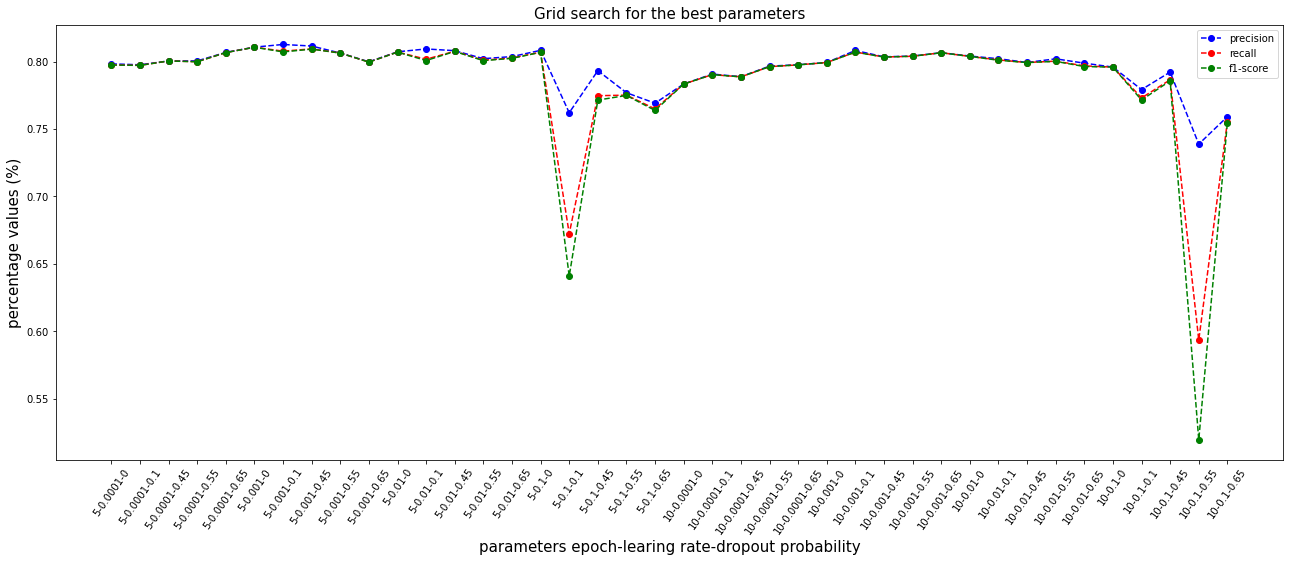

In [58]:
all_options_str = [f"{a}-{b}-{c}" for a,b,c in all_options]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.rcParams["figure.figsize"] = (22,8)

plt.xticks(rotation='55', fontsize=10)
ax.plot(all_options_str, precision_list, linestyle='--', marker='o', color='blue', label='precision')
ax.plot(all_options_str, recall_list, linestyle='--', marker='o', color='red', label='recall')
ax.plot(all_options_str, f1score_list, linestyle='--', marker='o', color='green', label='f1-score')
plt.title("Grid search for the best parameters", fontsize=15)
plt.xlabel("parameters epoch-learing rate-dropout probability", fontsize=15)
plt.ylabel("percentage values (%)", fontsize=15)

plt.legend()
plt.show();

In [60]:
input_dim = 384
num_classes = 2
learning_rate = 0.001 
num_epoch = 5
drop_probability = 0.1


In [61]:
model = NN_se(input_size=input_dim, num_classes=num_classes, p=drop_probability)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epoch):
    for data, labels in tqdm(train_loader):

        model_score = model(data)
        loss = criterion(model_score, labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
predicted_labels = output_numpy_array_from_model_training(test_loader, model)
print(sklearn.metrics.classification_report(test_data_labels, predicted_labels))

100%|███████████████████████| 70313/70313 [03:48<00:00, 308.13it/s]


              precision    recall  f1-score   support

           0       0.87      0.79      0.83    124929
           1       0.81      0.88      0.84    125071

    accuracy                           0.83    250000
   macro avg       0.84      0.83      0.83    250000
weighted avg       0.84      0.83      0.83    250000



### Specific for sentence embeddings

In [62]:
# sentence embeddings submission
submission_data_sentence_embeddings_tensor = torch.tensor(submission_data_sentence_embeddings).type(torch.float)
#submission_data_sentence_embeddings_tensor_scaled = F.normalize(submission_data_sentence_embeddings_tensor, p=1.0, dim=-1)
id_submit = torch.tensor(np.arange(0,10000)).type(torch.float)

In [63]:
submission_dataset = TensorDataset(submission_data_sentence_embeddings_tensor, id_submit)
submission_loader = DataLoader(dataset=submission_dataset, batch_size=batch_size,  shuffle=False)


submission_numpy_array = output_numpy_array_from_model_training(submission_loader, model)
submission_numpy_array

array([1., 1., 0., ..., 1., 0., 0.])

In [64]:
create_submission_file(submission_numpy_array)